In [1]:
import sys
import os
sys.path.append("../../TychePlot/")
from OLEDPlot import OLEDPlot
from Filereader import fileToNpArray,npArrayToFile
import numpy as np

In [2]:
vial_calib="calib/SH_vial_calib"
thinfilm_calib="calib/SH_thinfilm_calib"
sphere_calib="calib/SH_sphere_calib"

In [3]:
subdirnames=['perovskites_solution', 'perovskites_sphere', 'Thinfilm_perovskites']

In [4]:
file_format={
                "skiplines":1,
                "fileEnding":".tsv",
                "separator":"\t",
                "commaToPoint":True,
            }
clbr_format={
                "skiplines":1,
                "fileEnding":".clbr",
                "separator":"\t",
            }

In [5]:
files=[[os.path.join(subdir,file[:-4]) for file in os.listdir(subdir)] for subdir in subdirnames]
files

[['perovskites_solution/solution_sample_10rep_100ms_2020-10-06_13-56-26_',
  'perovskites_solution/solution_laser_10rep_100ms_2020-10-06_13-54-48_',
  'perovskites_solution/solution_sample_10rep_25ms_2020-10-06_13-57-15_',
  'perovskites_solution/solution_sample_out_of_beam_10rep_25ms_2020-10-06_13-58-18_'],
 ['perovskites_sphere/sphere_Laser_10rep_100ms_2020-10-06_13-12-29_',
  'perovskites_sphere/sphere_sample_N2_10rep_2s_2020-10-06_13-41-37_',
  'perovskites_sphere/sphere_glass_10rep_2s_2020-10-06_13-21-40_',
  'perovskites_sphere/sphere_sample_out_of_beam_N2_10rep_2s_2020-10-06_13-42-34_',
  'perovskites_sphere/sphere_glass_out_of_beam_10rep_2s_2020-10-06_13-23-19_',
  'perovskites_sphere/sphere_sample_10rep_100ms_2020-10-06_13-36-59_',
  'perovskites_sphere/sphere_sample_out_of_beam_N2_10rep_100ms_2020-10-06_13-43-31_',
  'perovskites_sphere/sphere_glass_out_of_beam_10rep_100ms_2020-10-06_13-24-38_',
  'perovskites_sphere/sphere_glass_10rep_100ms_2020-10-06_13-20-14_',
  'perovski

In [6]:
c=2.99793*10**8
h=6.623*10**-34
hc=h*c

In [7]:
calc_PLQE_with=[
                (0,'Laser','Sample','SamplePassive'),
                ('Laser','SampleLongExp','GlassLongExp','SamplePassiveLongExp','GlassPassiveLongExp','Sample','SamplePassive','GlassPassive','Glass',0),
                ('GlassLongExp','SamplePassiveLongExp','Sample','SamplePassive','Laser',0,'GlassPassiveLongExp','Glass','GlassPassive',0,'SampleLongExp'),
                ]

In [8]:
files_exp_rep=[[{"file":file,"exp_time":file.split("_")[-4][:-1],"rep":file.split("_")[-5][:-3]} for file in files_sub] for files_sub in files]

In [9]:
for files_sub in files_exp_rep:
    for file in files_sub:
        file['rep']=int(file['rep'])
        try:
            file['exp_time']=int(file['exp_time'])
        except ValueError as e:
            if str(e)[-2] =='m':
                file['exp_time']=int(file['exp_time'][:-1])/1000
         #file['exp_time']=

In [10]:
PLQE_inputs=[{key:value for key,value in zip(calc_PLQE_sub,files_sub) if key != 0} for calc_PLQE_sub,files_sub in zip(calc_PLQE_with,files_exp_rep)]

In [11]:
spectra_offset=[350,-100]
laser_thresh=420*10**-9

In [12]:
wavelengths=fileToNpArray(vial_calib, **clbr_format)[0][:,0][spectra_offset[0]:spectra_offset[1]]
laser_thresh_index=np.argwhere(wavelengths > laser_thresh)[0][0]
calibs={
            'vial_calib_vec':fileToNpArray(vial_calib, **clbr_format)[0][:,1][spectra_offset[0]:spectra_offset[1]],
            'thinfilm_calib_vec':fileToNpArray(thinfilm_calib, **clbr_format)[0][:,1][spectra_offset[0]:spectra_offset[1]],
            'sphere_calib_vec':fileToNpArray(sphere_calib, **clbr_format)[0][:,1][spectra_offset[0]:spectra_offset[1]]
}
calibs_input=['vial_calib_vec','sphere_calib_vec','thinfilm_calib_vec']

In [13]:
for PLQE_input,calib in zip(PLQE_inputs,calibs_input):
    PLQE_input['calib']=calibs[calib]
    for value in PLQE_input.values():
        try:
            value['spectra']=fileToNpArray(value['file'], **file_format)[0][:,1][spectra_offset[0]:spectra_offset[1]]
            value['spectra']/=value['exp_time']*value['rep']
            value['spectra']*=PLQE_input['calib']
        except IndexError:
            pass

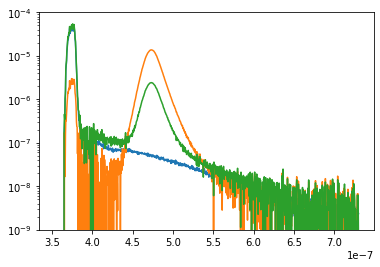

In [19]:
import scipy.interpolate as sci
import scipy.integrate as scin
import matplotlib.pyplot as plt
n=0
for PLQE_input in PLQE_inputs[0:1]:
    plt.figure(n)
    plt.plot(wavelengths, PLQE_input['Laser']['spectra'], wavelengths, PLQE_input['Sample']['spectra'], wavelengths, PLQE_input['SamplePassive']['spectra'])
    plt.ylim(10**-9,10**-4)
    plt.yscale("log")
    n+=1

In [15]:
### PAPER CALCS

In [21]:
## Summation
delta_x=[]
for x in range(0,len(wavelengths)-1):
    delta_x.append(wavelengths[x+1]-wavelengths[x])
L_a_midpoint_riemann_sum_elements=[]
L_b_midpoint_riemann_sum_elements=[]
L_c_midpoint_riemann_sum_elements=[]
for PLQE_dict in PLQE_inputs[0:1]:
    laser=PLQE_dict['Laser']['spectra']
    sample=PLQE_dict['Sample']['spectra']
    laser_sample=PLQE_dict['SamplePassive']['spectra']
    for x in range(0,len(delta_x)):
        L_a_midpoint_riemann_sum_elements.append(((laser[x]+laser[x+1])/2)*((wavelengths[x]+wavelengths[x+1])/2)/hc*delta_x[x])
        L_b_midpoint_riemann_sum_elements.append(((laser_sample[x]+laser_sample[x+1])/2)*((wavelengths[x]+wavelengths[x+1])/2)/hc*delta_x[x])
        L_c_midpoint_riemann_sum_elements.append(((sample[x]+sample[x+1])/2)*((wavelengths[x]+wavelengths[x+1])/2)/hc*delta_x[x])
    L_a_sum=sum(L_a_midpoint_riemann_sum_elements[:laser_thresh_index])
    L_b_sum=sum(L_b_midpoint_riemann_sum_elements[:laser_thresh_index])
    L_c_sum=sum(L_c_midpoint_riemann_sum_elements[:laser_thresh_index])
    P_a_sum=sum(L_a_midpoint_riemann_sum_elements[laser_thresh_index:])
    P_b_sum=sum(L_b_midpoint_riemann_sum_elements[laser_thresh_index:])
    P_c_sum=sum(L_c_midpoint_riemann_sum_elements[laser_thresh_index:])
    # 2 Step
    PLQY_2_step_sum=(P_c_sum)/(L_a_sum-L_c_sum)*100
    # 3 Step
    PLQY_3_step_sum=(P_c_sum-(L_c_sum/L_b_sum)*P_b_sum)/(L_a_sum*(1-L_c_sum/L_b_sum))*100
    print(
        f"\nPLQY by Summation:\n"+
        f"\nPLQY by 2 Step: {PLQY_2_step_sum:5.2f} %\nPLQY by 3 Step: {PLQY_3_step_sum:5.2f} %")

761834.6516665149
46978.40027822407

PLQY by Summation:

PLQY by 2 Step: 102.83 %
PLQY by 3 Step: 101.05 %


In [23]:
for PLQE_dict in PLQE_inputs[0:1]:
    laser=PLQE_dict['Laser']['spectra']
    sample=PLQE_dict['Sample']['spectra']
    laser_sample=PLQE_dict['SamplePassive']['spectra']
    ## Interpolation
    P_a_spectral_func=sci.interp1d(wavelengths,laser, kind='cubic')
    P_b_spectral_func=sci.interp1d(wavelengths,laser_sample, kind='cubic')
    P_c_spectral_func=sci.interp1d(wavelengths,sample, kind='cubic')
    # Integration
    L_a, L_a_err=scin.quad(lambda a: a*P_a_spectral_func(a)/hc,wavelengths[0],laser_thresh, limit=5000)
    L_b, L_b_err=scin.quad(lambda a: a*P_b_spectral_func(a)/hc,wavelengths[0],laser_thresh, limit=5000)
    L_c, L_c_err=scin.quad(lambda a: a*P_c_spectral_func(a)/hc,wavelengths[0],laser_thresh, limit=5000)
    P_a, P_a_err=scin.quad(lambda a: a*P_a_spectral_func(a)/hc,laser_thresh,wavelengths[-1], limit=5000)
    P_b, P_b_err=scin.quad(lambda a: a*P_b_spectral_func(a)/hc,laser_thresh,wavelengths[-1], limit=5000)
    P_c, P_c_err=scin.quad(lambda a: a*P_c_spectral_func(a)/hc,laser_thresh,wavelengths[-1], limit=5009)
    # 2 Step
    PLQY_2_step=(P_c)/(L_a-L_c)*100
    # 3 Step
    PLQY_3_step=(P_c-(L_c/L_b)*P_b)/(L_a*(1-L_c/L_b))*100
    print(
        f"\nPLQY by Integration:\n"+
        f"\nPLQY by 2 Step: {PLQY_2_step_sum:5.2f} %\nPLQY by 3 Step: {PLQY_3_step_sum:5.2f} %")

<ipython-input-23-6502d55bb3e1>:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  L_c, L_c_err=scin.quad(lambda a: a*P_c_spectral_func(a)/hc,wavelengths[0],laser_thresh, limit=5000)
<ipython-input-23-6502d55bb3e1>:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_a, P_a_err=scin.quad(lambda a: a*P_a_spectral_func(a)/hc,laser_thresh,wavelengths[-1], limit=5000)



PLQY by Integration:

PLQY by 2 Step: 102.83 %
PLQY by 3 Step: 101.05 %


<ipython-input-23-6502d55bb3e1>:14: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_b, P_b_err=scin.quad(lambda a: a*P_b_spectral_func(a)/hc,laser_thresh,wavelengths[-1], limit=5000)
<ipython-input-23-6502d55bb3e1>:15: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_c, P_c_err=scin.quad(lambda a: a*P_c_spectral_func(a)/hc,laser_thresh,wavelengths[-1], limit=5009)
